In [1]:
###########   Intro      ##################################

print("Initializing...")
print(r"""\
    ____                 _____                     __ 
   / __ \___  ___  ____ / ___/___  _____________  / /_
  / / / / _ \/ _ \/ __ \\__ \/ _ \/ ___/ ___/ _ \/ __/
 / /_/ /  __/  __/ /_/ /__/ /  __/ /__/ /  /  __/ /_  
/_____/\___/\___/ .___/____/\___/\___/_/   \___/\__/  
               /_/                 """)

Initializing...
\
    ____                 _____                     __ 
   / __ \___  ___  ____ / ___/___  _____________  / /_
  / / / / _ \/ _ \/ __ \\__ \/ _ \/ ___/ ___/ _ \/ __/
 / /_/ /  __/  __/ /_/ /__/ /  __/ /__/ /  /  __/ /_  
/_____/\___/\___/ .___/____/\___/\___/_/   \___/\__/  
               /_/                 


In [2]:

################## Import libraries ####################

print("Importing libraries...")

#Specify GPU modules to use
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import pandas as pd
import numpy as np
import tensorflow as tf
import timeit
from matplotlib import pyplot as plt
from scipy.stats import linregress
import shap
import threading, queue

import random
random.seed(7)

print("Import sucessfull...")

Importing libraries...
Import sucessfull...


In [3]:
######################  Loading data     #######################################
print("Loading dataset")
print("Importing RNAseq dataset...")

dataset_name = "qnorm_100_nos"

## Import train split
dataset_file1=np.load("results_clean_v11_X_train_%s.npy"%dataset_name,allow_pickle=True)
genes=np.load("genes_clean_v11_train_%s.npy"%dataset_name,allow_pickle=True)
samples=np.load("samples_clean_v11_train_%s.npy"%dataset_name,allow_pickle=True)
X_train=pd.DataFrame(dataset_file1,index=samples,columns=genes)

## Import test split
dataset_file=np.load("results_clean_v11_X_test_%s.npy"%dataset_name,allow_pickle=True)
genes=np.load("genes_clean_v11_test_%s.npy"%dataset_name,allow_pickle=True)
samples=np.load("samples_clean_v11_test_%s.npy"%dataset_name,allow_pickle=True)
X_test=pd.DataFrame(dataset_file,index=samples,columns=genes)

## Import hold-out split
dataset_file=np.load("results_clean_v11_out_%s.npy"%dataset_name,allow_pickle=True)
genes=np.load("genes_clean_v11_out_%s.npy"%dataset_name,allow_pickle=True)
samples=np.load("samples_clean_v11_out_%s.npy"%dataset_name,allow_pickle=True)
X_out=pd.DataFrame(dataset_file,index=samples,columns=genes)

## Import response variables
y_train=np.load("results_clean_v11_y_train_%s.npy"%dataset_name,allow_pickle=True)
y_test=np.load("results_clean_v11_y_test_%s.npy"%dataset_name,allow_pickle=True)
y_out=np.load("results_clean_v11_yout_%s.npy"%dataset_name,allow_pickle=True)


print("X_train shape: %s"%(str(X_train.shape)))
print("y_train shape: %s"%(str(y_train.shape)))
print("X_test shape: %s"%(str(X_test.shape)))
print("y_test shape: %s"%(str(y_test.shape)))

print("X_out shape: %s"%(str(X_out.shape)))
print("y_out shape: %s"%(str(y_out.shape)))

print("Dataset loaded")


Loading dataset
Importing RNAseq dataset...
X_train shape: (25028, 18952)
y_train shape: (25028, 1)
X_test shape: (25028, 18952)
y_test shape: (25028, 1)
X_out shape: (12515, 18952)
y_out shape: (12515, 1)
Dataset loaded


In [4]:

################################### Definition of Hyperparameters ##################################

print("Loading hyperparameters...")

model_name = "3-layers_drop_final"
iteration = "1"

nodes = X_train.shape[1]
factor = 1
initializer = "he_normal"
act_fun = "relu"
out_nodes = 1
out_fun = "linear"
loss_fun = "mean_squared_error"
optim = "Adam"

batch_size = 1024
epochs = 20

print("Hyperparameters loaded")

Loading hyperparameters...
Hyperparameters loaded


In [5]:
####################### Model definition ######################################

print("Defining Neural Network model...")

model = tf.keras.Sequential(name=model_name)
model.add(tf.keras.layers.Dense(units=nodes, input_dim=nodes, kernel_initializer=initializer, activation=act_fun, name="Input"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=int(nodes*factor), kernel_initializer=initializer, activation=act_fun, name="layer_1"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(out_nodes,activation=out_fun,name="Output"))
model.compile(loss=loss_fun, optimizer=optim)
    
model.summary()

print("Neural Network model defined")

Defining Neural Network model...
Model: "3-layers_drop_final"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (Dense)                (None, 18952)             359197256 
_________________________________________________________________
dropout (Dropout)            (None, 18952)             0         
_________________________________________________________________
layer_1 (Dense)              (None, 18952)             359197256 
_________________________________________________________________
dropout_1 (Dropout)          (None, 18952)             0         
_________________________________________________________________
Output (Dense)               (None, 1)                 18953     
Total params: 718,413,465
Trainable params: 718,413,465
Non-trainable params: 0
_________________________________________________________________
Neural Network model defined


In [6]:
#Start training
print("Training...")
tic=timeit.default_timer()

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),batch_size=batch_size,epochs=epochs)
toc=timeit.default_timer()

print("Training...done")
print("Training time: "+str((toc-tic)/60)+ " minutes")

Training...
Epoch 1/20
25/25 [==============================] - 20s 778ms/step - loss: 13701491870.9808 - val_loss: 4010878.0000
Epoch 2/20
25/25 [==============================] - 12s 485ms/step - loss: 2583501.7596 - val_loss: 1277705.6250
Epoch 3/20
25/25 [==============================] - 12s 487ms/step - loss: 1188060.7308 - val_loss: 676586.0625
Epoch 4/20
25/25 [==============================] - 12s 485ms/step - loss: 724107.9111 - val_loss: 340028.3125
Epoch 5/20
25/25 [==============================] - 12s 482ms/step - loss: 461726.0024 - val_loss: 256472.8281
Epoch 6/20
25/25 [==============================] - 12s 491ms/step - loss: 373960.0096 - val_loss: 237587.5625
Epoch 7/20
25/25 [==============================] - 12s 496ms/step - loss: 329419.8978 - val_loss: 209332.6562
Epoch 8/20
25/25 [==============================] - 12s 491ms/step - loss: 279242.7933 - val_loss: 185188.0938
Epoch 9/20
25/25 [==============================] - 12s 494ms/step - loss: 251011.0385 - va

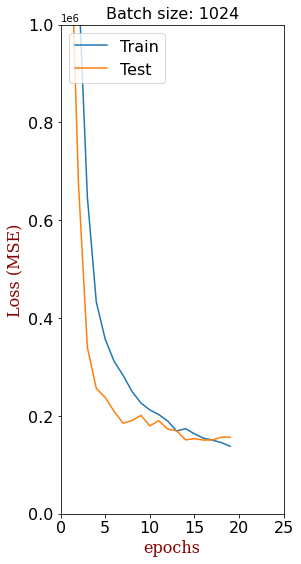

In [7]:
# Plot Loss over epochs
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
font2 = {'color':  'black',
        'weight': 'normal',
        'size': 10,
        }
plt.figure(figsize=(4,9))
plt.title('Batch size: {}'.format(str(batch_size)),fontsize=16)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel("epochs",fontdict=font)
plt.ylabel("Loss (MSE)",fontdict=font)
plt.ylim(0,1e6)
plt.xlim(0,25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(loc="upper left",fontsize=16)
plt.savefig("training_loss_%s_%s_%sb_%se_%s.svg"%(dataset_name,model_name,batch_size,epochs,iteration))

In [8]:
#Evaluation on hold-out set
eval_loss=model.evaluate(x=X_out,y=y_out)

392/392 [==============================] - 3s 9ms/step - loss: 156617.5312


Evaluating model...


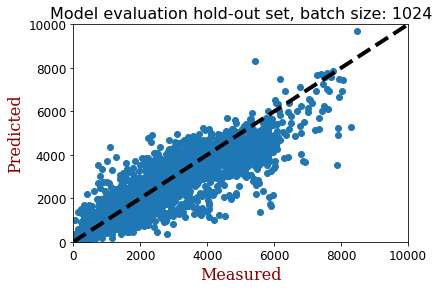

In [9]:
# Plot hold-out evaluation
print("Evaluating model...")

y_pred=model.predict(X_out)
y_pred=np.reshape(y_pred,(len(y_pred),))

plt.title('Model evaluation hold-out set, batch size: {}'.format(str(batch_size)),fontsize=16)
plt.scatter(y_out, y_pred)
plt.plot([0, 10000], [0,10000], 'k--', lw=4)
plt.ylim(0,10000)
plt.xlim(0,10000)
plt.xlabel("Measured",fontdict=font)
plt.ylabel("Predicted",fontdict=font)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("hold_out_accuracy_%s_%s_%sb_%se_%s.svg"%(dataset_name,model_name,batch_size,epochs,iteration))


In [10]:
X_out.shape

(12515, 18952)

In [11]:
y_pred.shape

(12515,)

In [12]:
y_out.shape

(12515, 1)

In [13]:
y_out=np.reshape(y_out,(len(y_out),))

In [14]:
y_out

array([ 529,  398, 1250, ...,  257, 2281,  852])

In [15]:
predictions=pd.DataFrame([y_pred,y_out]).T
predictions.columns=["y_pred","y_out"]
predictions.to_csv("predictions_%s_%s_%sb_%se_%s.csv"%(dataset_name,model_name,batch_size,epochs,iteration))

In [16]:
predictions[0:10]

,y_pred,y_out
0,444.148315,529.0
1,301.409729,398.0
2,1185.752563,1250.0
3,420.034485,443.0
4,1827.962524,1405.0
5,2869.338135,3104.0
6,3193.208496,3633.0
7,228.929123,278.0
8,555.450806,417.0
9,398.463715,521.0


In [17]:
y_pred

array([ 444.14832,  301.40973, 1185.7526 , ...,  235.67815, 3671.903  ,
        946.97437], dtype=float32)

In [18]:
y_out

array([ 529,  398, 1250, ...,  257, 2281,  852])

In [23]:
print("Successful training!")
slope, intercept, r_value, p_value, std_err = linregress(y_pred, y_out)
print("R²: " + str(r_value**2)+ " p_val: "+str(p_value))
##Print r2 score
file=open("r_scores.txt","a")
file.write( "{0}_{1}_{2}b_{3}e_{7} score: r2:{4}, std_err:{5}, p_val:{6}, eval_loss:{8}".format(dataset_name,model_name,batch_size,epochs,str(r_value**2),str(std_err),str(p_value),iteration,str(eval_loss))+"\n")
file.close()

Successful training!
R²: 0.9065146314810718 p_val: 0.0


In [24]:
#saving the model training history
pd.DataFrame(history.history).to_csv("history_{0}_{1}_{2}b_{3}e_{4}.csv".format(dataset_name,model_name,batch_size,epochs,iteration))

In [25]:
# select backgroud for shap
background = X_train.iloc[np.random.choice(X_test.shape[0], 100, replace=False)]
# DeepExplainer to explain predictions of the model
explainer = shap.DeepExplainer(model, background.values)
# compute shap values
shap_values = explainer.shap_values(X_test[:100].values)


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


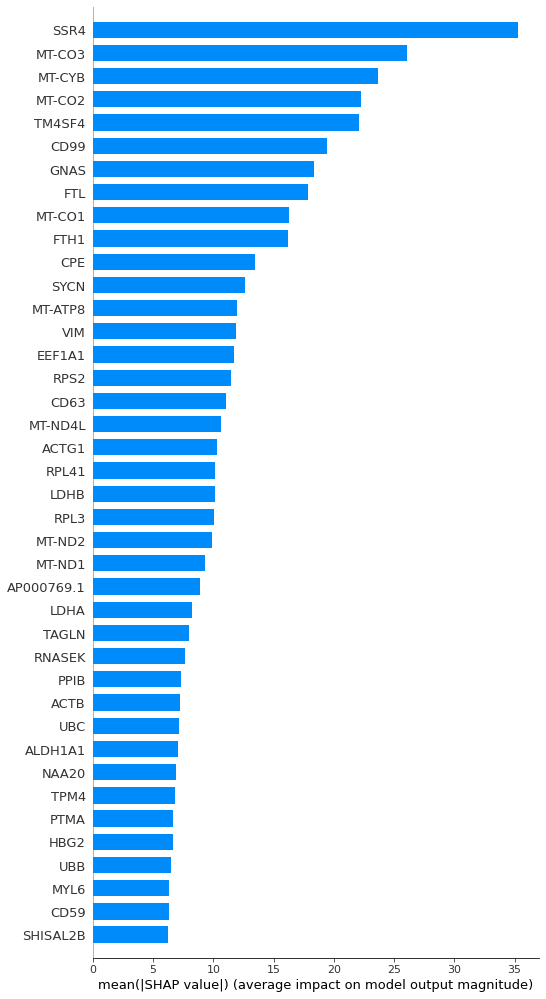

In [32]:
shap.summary_plot(shap_values[0],X_test[:100],max_display=40,plot_type="bar",show=False)
plt.savefig("shap_final.png")

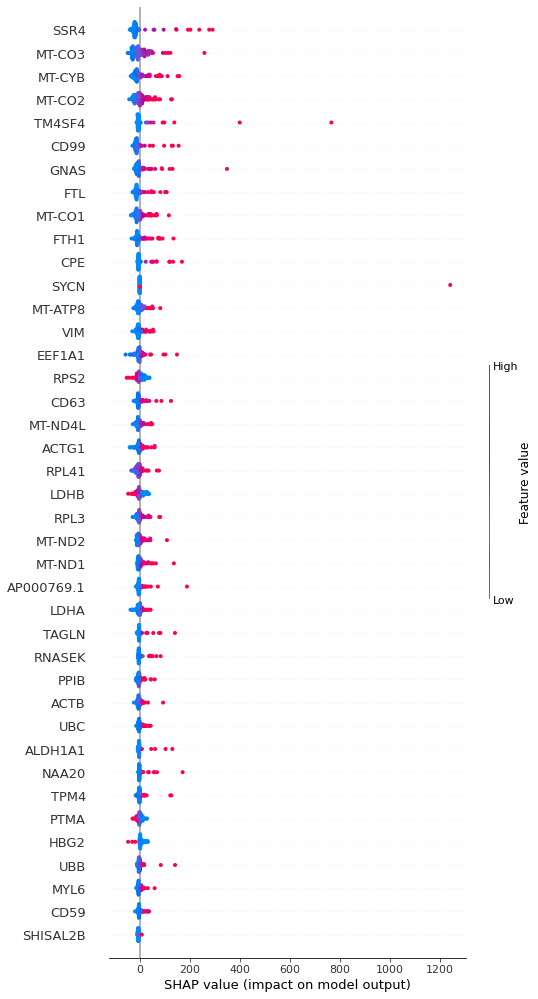

In [33]:
shap.summary_plot(shap_values[0],X_test[:100],max_display=40,show=False)
plt.savefig("shap_final_force")

In [34]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_test.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
feature_importance.head()

,col_name,feature_importance_vals
15498,SSR4,3528.308905
9715,MT-CO3,2605.941193
9716,MT-CYB,2370.207520
9714,MT-CO2,2223.755232
16367,TM4SF4,2210.219185


In [35]:
feature_importance.to_csv("shaps__{0}_{1}_{2}b_{3}e_{4}.csv".format(dataset_name,model_name,batch_size,epochs,iteration))

In [37]:
############## Saving model ###############
#model.save("TPM_qnorm_nos_100_3x1layers_1024b")

### Extracting feature importances from Neural Network

In [39]:
##generate random list of samples
n_samps = 100
samples=X_train.index.values
samples=random.sample(samples,k=int(n_samps))

In [40]:
subset=X_train.loc[samples].copy()

In [41]:
subset.head()

,A1CF,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,AADACL4,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
GSM2749296,1,1,1,1,1,42,1,1,1,1,...,93,1,1,1,1,1,1,1,1,70
GSM3530277,0,0,3,0,5,12,0,0,0,0,...,0,0,0,0,10,0,5,183,14,5
GSM5374079,0,0,0,0,98,9,0,0,0,0,...,12,126,0,1,5,4,5,232,7,15
GSM2652563,0,0,0,0,76,24,0,0,0,10,...,62,297,6,5,6,0,9,10,5,21
GSM4963877,0,0,16,0,16,12,0,0,0,0,...,128,84,8,0,21,0,0,69,10,0


In [42]:
impact=pd.DataFrame(index=subset.index.values, columns=subset.columns.values)

In [43]:
impact.head()

,A1CF,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,AADACL4,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
GSM2749296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM3530277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM5374079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM2652563,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GSM4963877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
y_before=model.predict(subset)

In [45]:
y_before[0:10]

array([[ 165.57925],
       [ 702.491  ],
       [ 207.66855],
       [ 273.6529 ],
       [ 294.99466],
       [ 210.48572],
       [4484.791  ],
       [ 227.76685],
       [4370.111  ],
       [2699.2573 ]], dtype=float32)

In [48]:
## Calculating residuals for a 10-fold overexpression of each gene

tic=timeit.default_timer()

q = queue.Queue()

def over_exp():
    while True:
        gene = q.get()
        y_before=model.predict(subset)
        subset[gene]=subset[gene]*10
        y_pred=model.predict(subset)
        subset[gene]=subset[gene]//10
        residual=y_pred-y_before
        #print("working on gene:{0}".format(gene))
        impact[gene]=(np.reshape(residual,(len(residual),1)))
        q.task_done()

# turn-on the worker thread
threading.Thread(target=over_exp, daemon=True).start()

# send thirty task requests to the worker
for gene in X_train.columns.values:
    q.put(gene)
print('All gene requests sent\n', end='')

# block until all tasks are done
q.join()
print('All work completed')
toc=timeit.default_timer()
print("Sorting time: "+str((toc-tic)/60)+ " minutes")

All gene requests sent
All work completed
Sorting time: 51.64975399713342 minutes


In [49]:
impact.to_csv("impact_factor_100_samples.csv")

In [50]:
y_after=model.predict(subset)

In [51]:
y_after[0:10]

array([[ 165.57925],
       [ 702.491  ],
       [ 207.66855],
       [ 273.6529 ],
       [ 294.99466],
       [ 210.48572],
       [4484.791  ],
       [ 227.76685],
       [4370.111  ],
       [2699.2573 ]], dtype=float32)

In [141]:
impact=impact.T

In [142]:
impact.head()

,A1CF,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,AADACL4,AADAT,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
GSM2749296,0.013428,-0.003204,0.002625,0.001022,0.003113,0.239258,0.006104,-0.003006,0.004288,-0.002502,...,0.242523,-0.002121,-0.000320,-0.002975,0.002090,0.000488,0.004532,0.000000,0.001694,0.262253
GSM3530277,0.000000,0.000000,0.334045,0.000000,0.009460,0.227173,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.275452,0.000000,0.339478,-2.317505,-0.093262,0.148315
GSM5374079,0.000000,0.000000,0.000000,0.000000,0.020462,0.003998,0.000000,0.000000,0.000000,0.000000,...,0.042068,1.563828,0.000000,0.006516,0.061508,0.019379,-0.026047,0.359344,0.018311,-0.021210
GSM2652563,0.000000,0.000000,0.000000,0.000000,0.434204,0.210602,0.000000,0.000000,0.000000,-0.178528,...,-0.071899,-3.956970,-0.004730,-0.047150,-0.064270,0.000000,0.118896,-0.021790,0.011414,0.103607
GSM4963877,0.000000,0.000000,0.191864,0.000000,-0.010681,0.080566,0.000000,0.000000,0.000000,0.000000,...,-0.079681,-1.251160,0.007538,0.000000,-0.226044,0.000000,0.000000,-0.215546,0.030792,0.000000


In [144]:
impact.drop_duplicates(keep='first', inplace=True)

In [145]:
impact=impact.T

In [146]:
sorted_genes=pd.DataFrame(columns=impact.columns.values,index=None)

In [147]:
sorted_genes

,GSM2749296,GSM3530277,GSM5374079,GSM2652563,GSM4963877,GSM2343454,GSM3546072,GSM5239594,GSM3544809,GSM3549159,...,GSM3548684,GSM5149794,GSM4861282,GSM2343652,GSM4330931,GSM4477119,GSM2932792,GSM5374161,GSM3546332,GSM4225919


In [150]:
for sample in sorted_genes.columns.values:
    sorted_genes[sample]=impact[sample].sort_values(ascending=False).index.values

In [151]:
sorted_genes

,GSM2749296,GSM3530277,GSM5374079,GSM2652563,GSM4963877,GSM2343454,GSM3546072,GSM5239594,GSM3544809,GSM3549159,...,GSM3548684,GSM5149794,GSM4861282,GSM2343652,GSM4330931,GSM4477119,GSM2932792,GSM5374161,GSM3546332,GSM4225919
0,H4C3,FTH1,MT-CO2,MT-CYB,TPM4,MT-CO2,MT-CYB,ACTG1,SSR4,CD44,...,MT-CYB,MT-CO1,MT-ND4L,MT-CO3,EEF1A1,SSR4,EEF1A1,MT-CO2,SYCN,MIA3
1,MT-CO3,CD74,MT-CO3,MT-CO1,RPS3,MT-CO3,FAM240C,TMSB4X,MT-CO3,MT-CO3,...,MT-CO3,ACTG1,CLDN11,MT-CO2,MT-CO1,MT-CYB,RPL41,MT-CO1,MT-CYB,NSMAF
2,RPL41,TPT1,MT-CO1,MT-CO3,SLC3A2,MT-ND4L,MT-CO3,GNAS,MT-CO2,SYCN,...,MT-CO2,TMSB10,FTH1,MT-ND4L,TAGLN,MT-CO3,MT-CO1,MT-CO3,MT-CO3,BACE1
3,RPS8,ACTB,MT-ATP8,MT-CO2,SEPTIN7,MT-CO1,MT-ND2,ACTB,MT-CYB,SAT1,...,RPL41,TMSB4X,SAR1A,MT-CO1,MT-CO3,MT-CO1,MT-CO2,MT-ATP8,MT-ND2,MYH9
4,RPS4X,FAM83A,MT-ND4,MT-ND1,H4C14,MT-ATP6,MT-CO2,MT-CO2,RPL41,MT-CYB,...,MT-ND2,MT-CO2,FTL,MT-ND4,ACTG1,CD99,GPC3,MT-ND4,GALNT2,HMGCL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18947,TUBA1A,RPS2,ENO1,GAGE12F,AP1S1,RPS26,SELENOW,RPSA,HSPA1A,CHD2,...,NACA,RPL32,BICC1,RPS9,RPL4,NPM1,NME2,SLC6A8,VMP1,GPM6B
18948,SNRPD1,KDM6B,FXYD5,CKS2,MLPH,RPL18,ADSL,RPS3A,GAPDH,GET4,...,RPL23,TMEM175,LRRC75A,RPL11,LDHB,FXYD3,RPS16,EEF1B2,BLVRB,ZNF502
18949,UBE2T,NACA,EEF1B2,FOLH1,HMGN1,EEF1B2,LAMTOR5,RPS21,CRYBA2,CCNL1,...,SNRPB,RPL5,AREG,EEF1B2,RPS2,ITGAV,NQO1,ACTG1,PSMD5,BRD8
18950,RPSA,ZFP36,SLC6A8,RPS2,G6PD,ACTG1,PSMA2,BEX3,RPL26,ITGAV,...,GAPDH,USP7,DPYSL2,EEF1A1,RPL23,TMSB4X,RPS2,RPS9,PRDX5,MTHFD1


In [152]:
sorted_genes.to_csv("sorted_candidates_99_samples.csv")

In [81]:
tic=timeit.default_timer()

##generating random list of samples


def multiplex(sample):
    print(f"running sample: {sample}")
    residuals=[]
    sample_rna=X_train.loc[sample].copy()
    y_pred_before=int(model.predict(np.array(sample_rna).reshape(1,-1)))
    #y_pred_before=regressor.predict(np.array(sample_rna).reshape(1,-1))
    print(f"y_pred_before: {y_pred_before}")
    for gene in genes:
        sample_rna[gene]=sample_rna[gene]*10 #overexpression 10x
        y_pred=int(model.predict(np.array(sample_rna).reshape(1,-1)))
        #y_pred=regressor.predict(np.array(sample_rna).reshape(1,-1))
        sample_rna[gene]=sample_rna[gene]/10 #restoring original value
        residuals.append([gene,y_pred-y_pred_before])
    gene_score=pd.DataFrame(residuals,columns=["gene_name","residual"])
    sorted_genes=gene_score.sort_values(by="residual",ascending=False).gene_name
    candidates[sample]=sorted_genes.values


print("Calculating residuals...")

for i in range(1,11,1):
    n_samps=1
    samples=np.load("samples_clean_v11_train_{0}.npy".format(dataset_name),allow_pickle=True)
    samples=choices(samples,k=int(n_samps))
#np.save("random_samples_100.npy",samples)
#samples=list(np.load("random_samples_100.npy",allow_pickle=True))
#samples=["GSM2817834"]

    candidates=pd.DataFrame() 
    with concurrent.futures.ThreadPoolExecutor() as executor:
            results=executor.map(multiplex,samples)
        
    print(f"Saving residuals file {i+1}")
    candidates.to_csv(f"candidates_table_tpm_{dataset_name}_{model_name}_{batch_size}b_{epochs}e-{i}.csv",index=False)
    print(f"File created")
    
toc=timeit.default_timer()
print("Sorting time: "+str((toc-tic)/60)+ " minutes")

Calculating residuals...
running sample: GSM3447363
y_pred_before: 236


KeyboardInterrupt: 

## Multiplex KO prediction

In [ ]:
tic=timeit.default_timer()

##generating random list of samples


def multiplex(sample):
    print(f"running sample: {sample}")
    residuals=[]
    sample_rna=X_train.loc[sample].copy()
    y_pred_before=int(regressor.predict(np.array(sample_rna).reshape(1,-1)))
    #y_pred_before=regressor.predict(np.array(sample_rna).reshape(1,-1))
    print(f"y_pred_before: {y_pred_before}")
    for gene in genes:
        sample_rna[gene]=sample_rna[gene]*10
        y_pred=int(regressor.predict(np.array(sample_rna).reshape(1,-1)))
        #y_pred=regressor.predict(np.array(sample_rna).reshape(1,-1))
        sample_rna[gene]=sample_rna[gene]/10
        residuals.append([gene,y_pred-y_pred_before])
    gene_score=pd.DataFrame(residuals,columns=["gene_name","residual"])
    sorted_genes=gene_score.sort_values(by="residual",ascending=False).gene_name
    candidates[sample]=sorted_genes.values


print("Calculating residuals...")

for i in range(2):
    n_samps=1
    samples=np.load("samples_clean_v10_train_tpm_50.npy",allow_pickle=True)
    samples=choices(samples,k=int(n_samps))
#np.save("random_samples_100.npy",samples)
#samples=list(np.load("random_samples_100.npy",allow_pickle=True))
#samples=["GSM2817834"]

    candidates=pd.DataFrame() 
    with concurrent.futures.ThreadPoolExecutor() as executor:
            results=executor.map(multiplex,samples)
        
    print(f"Saving residuals file {i+1}")
    candidates.to_csv(f"candidates_table_tpm_100_2layers_64b-{i+1}.csv",index=False)
    print(f"File created")
    
toc=timeit.default_timer()
print("Sorting time: "+str((toc-tic)/60)+ " minutes")

In [14]:
samples

['GSM2069477',
 'GSM3577398',
 'GSM2138846',
 'GSM3033043',
 'GSM2183982',
 'GSM2678771',
 'GSM3262231',
 'GSM2395568',
 'GSM2856927',
 'GSM3737430']

In [ ]:
n_samps=100
##generating random list of samples
samples=np.load("samples_qnorm_clean_v7_train_raw_100.npy",allow_pickle=True)
samples=choices(samples,k=int(n_samps))
np.save("random_samples_100.npy",samples)
samples=list(np.load("random_samples_100.npy",allow_pickle=True))
for i in range (10):
    samples=samples[i*10:(i+1)*10]

In [31]:
candidates.head()

,GSM2132131,GSM1633866
0,AC006987.5,AC011380.8
1,ABL1,AC073135.8
2,AC011043.1,AATK
3,AC004556.1,AC005517.3
4,ABCC1,AC073135.7


In [22]:
X_train.loc[samples]

,A1CF,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,AADACL3,AADACL4,AADAT,...,BP-21201H5.1,BP-21264C1.1,BP-2168N6.1,BP-2168N6.3,BP-2171C21.2,BP-2171C21.4,BP-2171C21.5,BP-2171C21.6,BP-2189O9.2,YR211F11.2
GSM1633866,14.226648,2853.403141,0.000000,0.0,874.265323,395.530069,0.0,0.0,0.0,0.000000,...,36.764706,5.797101,0.0,0.0,0.0,0.000000,68.181818,0.000000,10.386912,0.0
GSM2132131,1.778331,0.000000,873.593647,0.0,1231.108312,1420.379356,0.0,0.0,0.0,347.844199,...,542.279412,287.922705,0.0,0.0,0.0,4.692633,90.909091,168.776371,41.547650,0.0


In [27]:
tic=timeit.default_timer()

candidates=pd.DataFrame() 

def iterator(gene):
    #sample_rna=X_train.loc[sample].copy()
    y_pred_before=int(regressor.predict(np.array(sample_rna).reshape(1,-1)))
    sample_rna[gene]=sample_rna[gene]*10
    y_pred=regressor.predict(np.array(sample_rna).reshape(1,-1))
    sample_rna[gene]=sample_rna[gene]/10
    residuals.append((gene,y_pred-y_pred_before))
    

for sample in samples:
    print(f"running sample: {sample}")
    sample_rna=X_train.loc[sample].copy()
    residuals=[]
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results=executor.map(iterator,(genes[0:1000]))
        #gene_score=pd.DataFrame(residuals,columns=["gene_name","residual"])
        #sorted_genes=gene_score.sort_values(by="residual",ascending=False).gene_name
        #candidates[sample]=sorted_genes.values
    
toc=timeit.default_timer()
print("Predicting time: "+str((toc-tic)/60)+ " minutes")

running sample: GSM1633866


KeyboardInterrupt: 

In [10]:
from multiprocessing.pool import ThreadPool

def iterator(gene):
    sample_rna=X_train.loc[sample].copy()
    y_pred_before=int(regressor.predict(np.array(sample_rna).reshape(1,-1)))
    sample_rna[gene]=sample_rna[gene]*10
    y_pred=regressor.predict(np.array(sample_rna).reshape(1,-1))
    residuals.append((gene,y_pred-y_pred_before))


tic=timeit.default_timer()
candidates=pd.DataFrame()

def predictor(sample):
    print(f"processing sample {sample}")
    residuals=[]
    pool=ThreadPool()
    results_pool=pool.map(iterator,genes[0:100])
    gene_score=pd.DataFrame(residuals,columns=["gene_name","residual"])
    sorted_genes=gene_score.sort_values(by="residual",ascending=False).gene_name
    candidates[sample]=sorted_genes.values


for sample in samples:
    predictor(sample)


toc=timeit.default_timer()

print("Predicting time: "+str((toc-tic)/60)+ " minutes")

processing sample GSM2915858


NameError: name 'residuals' is not defined

In [36]:
from multiprocessing.pool import ThreadPool

def iterator(gene):
    sample_rna=X_train.loc[sample].copy()
    y_pred_before=int(regressor.predict(np.array(sample_rna).reshape(1,-1)))
    sample_rna[gene]=sample_rna[gene]*10
    y_pred=regressor.predict(np.array(sample_rna).reshape(1,-1))
    residuals.append((gene,y_pred-y_pred_before))


tic=timeit.default_timer()
candidates=pd.DataFrame()
for sample in samples:
    residuals=[]
    pool=ThreadPool()
    results_pool=pool.map(iterator,genes[0:100])
    gene_score=pd.DataFrame(residuals,columns=["gene_name","residual"])
    sorted_genes=gene_score.sort_values(by="residual",ascending=False).gene_name
    candidates[sample]=sorted_genes.values

toc=timeit.default_timer()

print("Predicting time: "+str((toc-tic)/60)+ " minutes")

Predicting time: 0.20427204145040984 minutes


In [ ]:

print("Saving residuals file...")
candidates.to_csv("candidates_table_QT50_raw.csv")
toc=timeit.default_timer()
print("Predicting time: "+str((toc-tic)/60)+ " minutes")

print("Prediction of candidates successful!")
